In [7]:
# visual confirmation of ICs
# get 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];

for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];

200920-23:03:35,737 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
PD :  40
ET :  29
NC :  33


In [8]:
# corr IC * subj
import nibabel as nib
import time
ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
nc_jaco_x_list=[]
i_PD_IC=0
PD_ICA_img=nib.load(ic_list[i_PD_IC]);

def grab_group_corr_ICA_all_sv(ic_list, img_list, id_list, out_dir):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; 
    N_ic=len(ic_list);
    N_sub=len(img_list);
    #print('gourp++')
    for j in range(N_ic):
        y_list=[]
        for i in range(N_sub):
            # cal img * img
            ic_img=nib.load(ic_list[j])
            sub_img=nib.load(img_list[i])
            sub_img_re = resample_to_img(sub_img, ic_img)
            #sub_img_x  = math_img("img1 * img2", img1=ic_img, img2=sub_img_re)
            #nib.save(sub_img_x, out_dir+id_list[i]+'-xIC'+str(j)+'.nii.gz');
            # cal naive corr
            ic_data = ic_img.get_fdata().reshape(-1);
            nz_pos=np.flatnonzero(ic_data)
            ic_val=list(ic_data.ravel()[nz_pos])
            sub_dat = sub_img_re.get_fdata().reshape(-1);
            sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
            #_list.append([sub_img_x, np.corrcoef(sub_val, ic_val)[0,1]])
            y_list.append(np.corrcoef(sub_val, ic_val)[0,1])
        x_list.append(y_list)
    return x_list
##
# just look at ic7
ic7_list=[ic_list[i_PD_IC]]
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
t0=time.time()
nc_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, nc_jaco_list, nc_sub_list, ICx_OUT_DIR)
print('NC group corr IC takes: ', str(time.time()-t0))
pd_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, pd_jaco_list, pd_sub_list, ICx_OUT_DIR)
print('NC+PD group corr IC takes: ', str(time.time()-t0))
et_jaco_corr_list=grab_group_corr_ICA_all_sv(ic7_list, et_jaco_list, et_sub_list, ICx_OUT_DIR)
print('all group corr IC takes: ', str(time.time()-t0))
import pandas as pd
ic7_corr=pd_jaco_corr_list[0]+et_jaco_corr_list[0]+nc_jaco_corr_list[0]
ic_corr_lable=['PD']*N_PD+['ET']*N_ET+['NC']*N_NC
group_corr=pd.DataFrame({'IC Correlation': ic7_corr, 'Study Group': ic_corr_lable})
group_corr.to_csv('group_ic-sub_corr_ic0.csv')
print(group_corr)

NC group corr IC takes:  312.8304274082184
NC+PD group corr IC takes:  693.8487446308136
all group corr IC takes:  973.2404577732086
     IC Correlation Study Group
0         -0.007844          PD
1         -0.024517          PD
2         -0.042457          PD
3         -0.011653          PD
4         -0.053182          PD
5         -0.045750          PD
6         -0.082783          PD
7         -0.020670          PD
8         -0.026993          PD
9          0.033284          PD
10        -0.068665          PD
11         0.019783          PD
12        -0.063231          PD
13         0.026227          PD
14         0.000528          PD
15        -0.050796          PD
16        -0.006466          PD
17         0.022003          PD
18        -0.038971          PD
19        -0.014440          PD
20        -0.026129          PD
21        -0.120917          PD
22        -0.063564          PD
23        -0.027162          PD
24         0.003772          PD
25        -0.067222          PD
26 

In [14]:
# plot and sv Dagher 30 ICs
from nilearn import plotting
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/figs'
atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
N_ic = len(ic_list)
i_ic=7
VMIN= 3; VMAX=16; # vmin=VMIN;
#plotting.plot_glass_brain(ic_list[i_ic], title='no th '+str(i_ic)+', with TH=0', display_mode='lyrz',
#                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=5)
plotting.plot_stat_map(ic_list[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3, vmax=VMAX, \
                       title="PD-ICA Axial", draw_cross=False, cut_coords=[-12, -7,  20], \
                       output_file=OUT_DIR+'/PD-ICA_Axial.png')
plotting.plot_stat_map(ic_list[i_ic], bg_img=atlas_09_masked, display_mode='x', threshold=3, vmax=VMAX, \
                       title="PD-ICA Sagittal", draw_cross=False, cut_coords=[-12, -7, 20], \
                      output_file=OUT_DIR+'/PD-ICA_Sagittal.png')
plotting.plot_stat_map(ic_list[i_ic], bg_img=atlas_09_masked, display_mode='y', threshold=3, vmax=VMAX, \
                       title="PD-ICA Coronal", draw_cross=False, cut_coords=[-12, -7, 20], \
                      output_file=OUT_DIR+'/PD-ICA_Coronal.png')

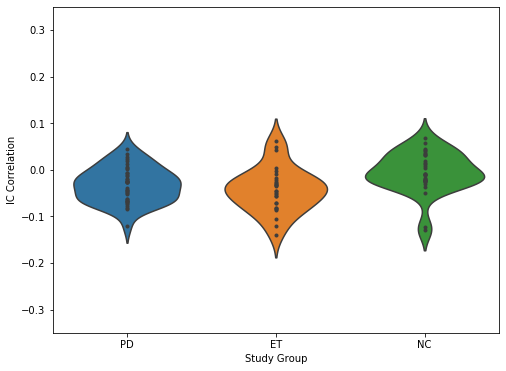

In [9]:
#plot group corr
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
group_corr = pd.read_csv('group_ic-sub_corr_ic0.csv', sep=',', header=0, index_col=0)
#group_corr=pd.DataFrame({'IC Correlation': ic7_corr, 'Study Group': ic_corr_lable})
plt.figure(1, figsize=(8, 6))
ax = sns.violinplot(x="Study Group", y="IC Correlation", data=group_corr, inner='point')
plt.ylim(-0.35, 0.35)
plt.savefig('group_corr_ic0.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use({'figure.figsize':(12, 8)})
vmin1=-.2; vmax1 = .2
df=[df_1, df_2, df_3];
# Fixing random state for reproducibility
#np.random.seed(19680801)
fig, axs = plt.subplots(1, 3)

cm = ['RdBu_r', 'viridis']
ax2 = axs[1]
pcm2 = ax2.imshow(df_1, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax2.set_title("y=IC, x=NC subjects")
#fig.colorbar(pcm1, ax=ax1)
ax1 = axs[0]
pcm1 = ax1.imshow(df_2, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax1.set_title("y=IC, x=PD subjects")
ax3 = axs[2]
pcm3 = ax3.imshow(df_3, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax3.set_title("y=IC, x=ET subjects")
fig.colorbar(pcm3, ax=ax3)
plt.show()